**下面这部分为测试CUDA device_array的可操作性**

In [31]:
from numba import jit,prange,cuda,vectorize,float32,float64 #牢记prange也要导入
import numba
import numpy as np

a_device=cuda.device_array(shape=(5,5),dtype=np.float32)
b_device=cuda.device_array(shape=(5,5),dtype=np.float32)
a_device=a_device+np.float32(5.0)
#要点：CUDA的GPU array不支持直接的数学运算，必须写kernel来执行。若直接进行数学运算，CUDA的GPU array会被拷贝至CPU，然后再执行运算，这样效率很低
print(a_device)

a_device=cuda.to_device(np.arange(5))
b_device=cuda.to_device(np.zeros(5))
print(b_device)
a_device[2]=b_device[0]
#要点：CUDA的GPU array支持用一个GPU array给另一个GPU array赋值，赋值过程依然在GPU上完成
a_host=a_device.copy_to_host()
print(a_host)

ary=np.arange(10)
print(ary)
d_ary=cuda.to_device(ary)
d_ary[0:4]=np.array([100,101,102,103],dtype=np.float32)
#要点：CUDA的GPU array支持根据索引（包括切片操作）赋值，但是会将赋入的值的数据类型直接强制转换到GPU array的数据类型，赋值过程依然在GPU上完成
print(d_ary)
hary=d_ary.copy_to_host()
print(hary)
print(numba.typeof(hary[0]))

[[ 5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.]]
[0 1 0 3 4]
[0 1 2 3 4 5 6 7 8 9]
[100 101 102 103   4   5   6   7   8   9]
int32


**以下为测试使用numba的随机数生成器给2D array赋值**

**测试结果：numba的随机数生成器在array尺寸很大时很糟糕**

In [1]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float32
from numba import jit,prange,cuda,vectorize,float32,float64 #牢记prange也要导入
import numpy as np
import math

@cuda.jit
def kernel_noise(rng_states,MatA):
    x=cuda.threadIdx.x+cuda.blockIdx.x*cuda.blockDim.x
    y=cuda.threadIdx.y+cuda.blockIdx.y*cuda.blockDim.y
    offset=x+y*cuda.blockDim.x*cuda.gridDim.x
    if offset<MatA.shape[0]*MatA.shape[1]:
        MatA[offset]=xoroshiro128p_normal_float32(rng_states,offset)

In [2]:
a=np.empty(shape=(128,128),dtype=np.float32)
a_device=cuda.to_device(a)
#a_device=cuda.device_array(shape=(128,128),dtype=np.float32)

In [3]:
threadsperblock=(32,32) #要点：这个设定要根据显卡类型决定！我目前的显卡的block内的线程只能支持到32
blockspergrid_x=math.ceil(a.shape[0]/threadsperblock[0])
blockspergrid_y=math.ceil(a.shape[1]/threadsperblock[1])
blockspergrid=(blockspergrid_x,blockspergrid_y)
rng_states=create_xoroshiro128p_states(blockspergrid_x*threadsperblock[0]*blockspergrid_y*threadsperblock[1], seed=1)

In [4]:
kernel_noise[blockspergrid,threadsperblock](rng_states,a_device)

**以下为将numpy array保存为二进制文件和读取二进制文件的示例代码**

In [1]:
import numpy as np
a=np.arange(4096*4096)
a.shape=(4096,4096)
#print(a.dtype)
filename1='test'+'.bin'
filename2='test'+'.txt'
#a.tofile(filename)
#c=np.fromfile(filename,dtype=np.int32)
#c.shape=(3,3)

In [2]:
%timeit a.tofile(filename1) #还是这种方式快，特别是在存大尺寸矩阵时！

259 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%timeit np.savetxt(filename2,a)

7.69 s ± 608 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**以下为按顺序保存文件的示例代码，注意str.zfill这个字符method的运用**

In [11]:
c1=0
for i in range(5):
    c1+=1
    filename1=str(c1).zfill(6)+'_1.bin'
    print(filename1)

000001_1.bin
000002_1.bin
000003_1.bin
000004_1.bin
000005_1.bin


**以下为按顺序循环读取文件的示例代码**

In [4]:
import numpy as np

#data=np.empty((1001,1024,1024),dtype=np.float32)
for i in range(0,12):
    data=np.empty((1001,1024,1024),dtype=np.float32)
    for j in range(1,12):
        filename = '%05d_%d_0.bin'%(j,i) #j对应05d，其中05d中0表示位数不够时前面用0补，5表示5位，d表示数字。i对应d，d表示数字，表示没有特定格式
        print(filename)
        c=np.fromfile(filename,dtype=np.float32)
        c.shape=(1024,1024)
        data[j-1,:,:]=c
#      data.append(np.reshape(c,(1024,1024))) #用.append()这个method实现array在第三维上（时间维）的合并
    
#data = np.array(ans)

00001_0_0.bin
00002_0_0.bin
00003_0_0.bin
00004_0_0.bin
00005_0_0.bin
00006_0_0.bin
00007_0_0.bin
00008_0_0.bin
00009_0_0.bin
00010_0_0.bin
00011_0_0.bin
00001_1_0.bin
00002_1_0.bin
00003_1_0.bin
00004_1_0.bin
00005_1_0.bin
00006_1_0.bin
00007_1_0.bin
00008_1_0.bin
00009_1_0.bin
00010_1_0.bin
00011_1_0.bin
00001_2_0.bin
00002_2_0.bin
00003_2_0.bin
00004_2_0.bin
00005_2_0.bin
00006_2_0.bin
00007_2_0.bin
00008_2_0.bin
00009_2_0.bin
00010_2_0.bin
00011_2_0.bin
00001_3_0.bin
00002_3_0.bin
00003_3_0.bin
00004_3_0.bin
00005_3_0.bin
00006_3_0.bin
00007_3_0.bin
00008_3_0.bin
00009_3_0.bin
00010_3_0.bin
00011_3_0.bin
00001_4_0.bin
00002_4_0.bin
00003_4_0.bin
00004_4_0.bin
00005_4_0.bin
00006_4_0.bin
00007_4_0.bin
00008_4_0.bin
00009_4_0.bin
00010_4_0.bin
00011_4_0.bin
00001_5_0.bin
00002_5_0.bin
00003_5_0.bin
00004_5_0.bin
00005_5_0.bin
00006_5_0.bin
00007_5_0.bin
00008_5_0.bin
00009_5_0.bin
00010_5_0.bin
00011_5_0.bin
00001_6_0.bin
00002_6_0.bin
00003_6_0.bin
00004_6_0.bin
00005_6_0.bin
00006_

In [26]:
import numpy as np

data=np.empty((13,1024,1024),dtype=np.float32) #每个case生成一个空矩阵，这里假设在下面的文件夹内只有1个case以及相应的13个model result
for i in range(0,13):
    path = 'D:\\testdir/' #\后为t时需要两个\\，不然会被理解成换行符，类似的还有n，其他字母可用单斜杠
    file = '%05d_%d_0.bin'%(1,i)
    filename = path + file
    temp = np.fromfile(filename,dtype=np.float32)
    temp.shape = (1024,1024)
    data[i,:,:] = temp

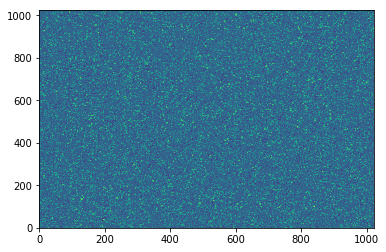

In [27]:
import matplotlib.pyplot as plt
plt.contourf(data[6,:,:])
plt.show()

**以下为利用OS操作文件的示例代码**

In [12]:
import os

# entries = os.listdir('D:\my_directory/') #老版本python返回指定路径文件夹内文件序列的命令
entries = os.scandir('D:\my_directory/') #新版本python返回指定路径文件夹内文件序列的命令，返回了一个可用于迭代的迭代器
#<nt.ScandirIterator object at 0x00000207A9E45C60>
for entry in entries: #读取文件名
    if entry.is_file(): #判断是否为文件，将子文件夹排除
        print(entry.name) 
os.mkdir('D:\example_directory/') #在指定路径创建文件夹

file1.py
file2.csv
file3.txt


**以下结合matlab的例子测试numpy的ifft2与matlab的ifft2的差异**
**测试结果：numpy的ifft2与matlab的ifft2采用的算法不同，numpy的ifft2结果相比于matlab的ifft2结果会多一个虚数部分，在实际应用时可直接忽略numpy的ifft2结果中的虚数部分**

In [2]:
import numpy as np
from scipy import interpolate

O=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[5,3,6,9]])
print(O)
A=np.fft.fft2(O)
print(A)
B=np.power(np.absolute(A),2) 
print(B)
B[0,0]=0 
print(B)
C=np.fft.fftshift(np.fft.ifft2(B))
print(C)
#X=np.arange(-3,3)
#Y=np.arange(-3,3)
#Fcircle=interpolate.interp2d(X,Y,C,kind='linear')

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [ 5  3  6  9]]
[[ 101. +0.j   -7.+12.j   -7. +0.j   -7.-12.j]
 [ -32. -3.j   -4. +1.j    0. +1.j    4. +1.j]
 [   3. +0.j   -1. -4.j   -1. +0.j   -1. +4.j]
 [ -32. +3.j    4. -1.j    0. -1.j   -4. -1.j]]
[[  1.02010000e+04   1.93000000e+02   4.90000000e+01   1.93000000e+02]
 [  1.03300000e+03   1.70000000e+01   1.00000000e+00   1.70000000e+01]
 [  9.00000000e+00   1.70000000e+01   1.00000000e+00   1.70000000e+01]
 [  1.03300000e+03   1.70000000e+01   1.00000000e+00   1.70000000e+01]]
[[  0.00000000e+00   1.93000000e+02   4.90000000e+01   1.93000000e+02]
 [  1.03300000e+03   1.70000000e+01   1.00000000e+00   1.70000000e+01]
 [  9.00000000e+00   1.70000000e+01   1.00000000e+00   1.70000000e+01]
 [  1.03300000e+03   1.70000000e+01   1.00000000e+00   1.70000000e+01]]
[[-147.5625+0.j -131.5625+0.j -103.5625+0.j -131.5625+0.j]
 [ -19.5625+0.j   -3.5625+0.j   24.4375+0.j   -3.5625+0.j]
 [ 102.4375+0.j  126.4375+0.j  163.4375+0.j  126.4375+0.j]
 [ 

In [4]:
import numpy as np

A=np.random.randn(5,3,3)
print(A)
B=np.delete(A,0,axis=0)
print(B)

[[[-0.0223253  -1.540457   -1.24955913]
  [-1.22203364 -0.85450359  1.49795829]
  [-0.95657672 -0.83692037 -0.1982353 ]]

 [[-1.47149751  0.4079488  -1.36159134]
  [-0.13266783  1.69355388  1.66845258]
  [ 0.37226142 -0.41729746  0.0490074 ]]

 [[-0.21784167 -1.54119483 -0.77927389]
  [-1.82346134  0.83325883  0.4776453 ]
  [ 0.60941533  1.3556699   0.13571079]]

 [[-0.82593637 -1.58262984  1.45504124]
  [-0.94827419  0.22200764 -1.05283611]
  [ 1.16682058  0.50116945  0.82512045]]

 [[ 1.08581921  0.55522719  0.63445089]
  [-0.9875015  -1.30933053 -1.70459528]
  [ 0.71257126  0.73626956  0.53313909]]]
[[[-1.47149751  0.4079488  -1.36159134]
  [-0.13266783  1.69355388  1.66845258]
  [ 0.37226142 -0.41729746  0.0490074 ]]

 [[-0.21784167 -1.54119483 -0.77927389]
  [-1.82346134  0.83325883  0.4776453 ]
  [ 0.60941533  1.3556699   0.13571079]]

 [[-0.82593637 -1.58262984  1.45504124]
  [-0.94827419  0.22200764 -1.05283611]
  [ 1.16682058  0.50116945  0.82512045]]

 [[ 1.08581921  0.555227